### Comparison with ADAPT Training Data and FC TOW

- Clipped FC-TOW to Training Squares NL
- Clipped FC-NFI to Training Squares NL
- Merged Clipped FC-TOW with FC-NFI
- Used Training data for NL - C1 & C2

**Further Ideas/Thoughts**

- Looks like the TOW under predicts hedgerow trees and single trees 
- What is the TOW height threshold?
- Impressive Natioinal Data set
- ADAPT looks very good (to say its just using RGB!)


In [33]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Paths to the shapefiles
labels_train_path = r"..\content\labels_eco\labels_train.shp"
sample_sqs_train_path = r"..\content\labels_eco\sample_sqs_train.shp"

# Load the shapefiles
labels_train = gpd.read_file(labels_train_path)
sample_sqs_train = gpd.read_file(sample_sqs_train_path)

#### Prep the FC data

In [9]:
# Paths to the FC shapefiles
fc_nfi_path = r"..\content\tow\NFI__NL_Clip.shp"
fc_tow_path = r"..\content\tow\FR_TOW_V1_East__NL_Clip.shp"

# Load the FC shapefiles
fc_nfi = gpd.read_file(fc_nfi_path)
fc_tow = gpd.read_file(fc_tow_path)

In [10]:
fc_nfi.columns

Index(['OBJECTID_2', 'OBJECTID', 'CATEGORY', 'IFT_IOA', 'COUNTRY', 'Area_ha',
       'Shape__Are', 'Shape__Len', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

In [14]:
fc_nfi['IFT_IOA'].unique()

array(['Bare area', 'Grassland', 'Urban', 'Other vegetation',
       'Assumed woodland', 'Broadleaved', 'Conifer', 'Felled',
       'Ground prep', 'Mixed mainly broadleaved', 'Mixed mainly conifer',
       'Young trees', 'Shrub', 'Windblow'], dtype=object)

In [11]:
fc_tow.columns

Index(['TOW_ID', 'Woodland_T', 'MEANHT', 'MINHT', 'MAXHT', 'STDVHT',
       'KM1_Tile', 'KM10_TILE', 'TOW_Area_M', 'LiDAR_Surv', 'SHAPE_Leng',
       'SHAPE_Area', 'geometry'],
      dtype='object')

In [13]:
fc_tow['Woodland_T'].unique()

array(['NFI OHC', 'Group of Trees', 'Lone Tree', 'Small Woodland'],
      dtype=object)

In [18]:
# Subset the FC NFI data
fc_nfi_subset = fc_nfi[fc_nfi['IFT_IOA'].isin(['Assumed woodland', 'Broadleaved',
                                                      'Conifer', 'Mixed mainly broadleaved',
                                                      'Mixed mainly conifer','Young trees'])]

In [21]:
fc_nfi_subset['IFT_IOA'].unique()

array(['Assumed woodland', 'Broadleaved', 'Conifer',
       'Mixed mainly broadleaved', 'Mixed mainly conifer', 'Young trees'],
      dtype=object)

In [27]:
# Perform a spatial union (combines geometries and attributes)
merged_gdf = gpd.overlay(fc_nfi_subset, fc_tow, how='union')

# Check the result
path_merged = r"..\content\tow\merged_output.shp"
merged_gdf.to_file(path_merged, driver='ESRI Shapefile')

C:\Users\alexad\AppData\Local\Temp\ipykernel_848\1644475992.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 32 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  merged_gdf = gpd.overlay(fc_nfi_subset, fc_tow, how='union')
c:\Users\alexad\AppData\Local\anaconda3\envs\geo\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAPE_Leng' to 'SHAPE_Le_1'
  ogr_write(
c:\Users\alexad\AppData\Local\anaconda3\envs\geo\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'SHAPE_Area' to 'SHAPE_Ar_1'
  ogr_write(


#### Prep the Labels

In [29]:
labels_train['ADAPT'].unique()

array(['F3d', 'C1', 'C4', 'E2b', 'E2a', 'D2b', 'D1a', '0', 'D6a', 'C2',
       'C5', 'D3'], dtype=object)

In [30]:
labels_train_subset = labels_train[labels_train['ADAPT'].isin(['C1', 'C2'])]

In [31]:
labels_train_subset['ADAPT'].unique()

array(['C1', 'C2'], dtype=object)

## Comparison

In [45]:
# intersection of both datasets
intersection = gpd.overlay(labels_train_subset, merged_gdf, how='intersection')

# Calculate areas for comparison
intersection_area = intersection.area.sum()
labels_area = labels_train_subset.area.sum()
fc_nfi_tow_area = merged_gdf.area.sum()

# Print out areas for comparison
print(f"Intersection Area: {intersection_area}")
print(f"Labels Area: {labels_area}")
print(f"fc_nfi Area: {fc_nfi_tow_area}")

Intersection Area: 1770442.7424622076
Labels Area: 2143774.852551196
fc_nfi Area: 2786900.2555853357


C:\Users\alexad\AppData\Local\Temp\ipykernel_848\700442040.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 37 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection = gpd.overlay(labels_train_subset, merged_gdf, how='intersection')


In [47]:
# Calculate Intersection over Union (IoU)
iou = intersection_area / (labels_area + fc_nfi_tow_area - intersection_area)
print(f"Intersection over Union (IoU): {iou}")

Intersection over Union (IoU): 0.5602254953440534


C:\Users\alexad\AppData\Local\Temp\ipykernel_848\3157855075.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


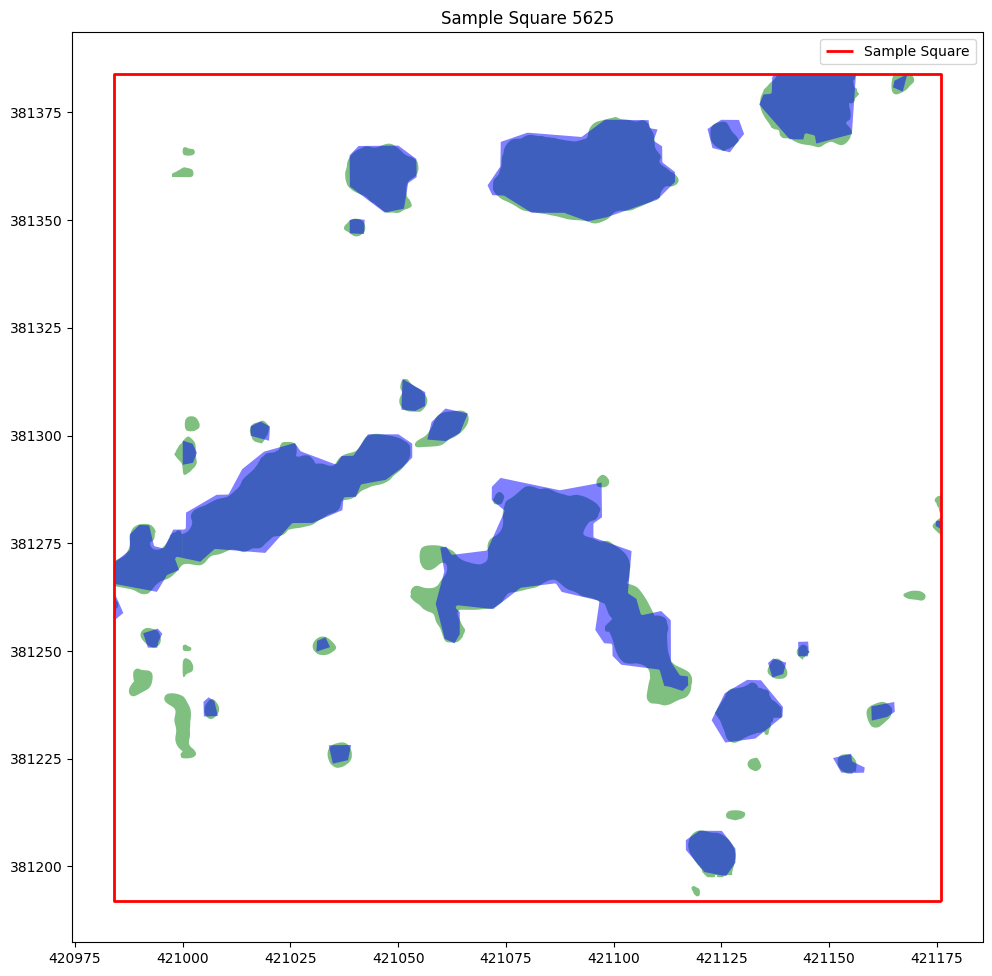

In [52]:
# Example plot
square_number = 5625  # select a sq

# Filter 
square = sample_sqs_train[sample_sqs_train['sample_sq'] == square_number].iloc[0]

# Plot 
fig, ax = plt.subplots(figsize=(10, 10))

# Filter data for the current square
square_geom = square['geometry']
labels_in_square = labels_train_subset[labels_train_subset.intersects(square_geom)]
fc_nfi_in_square = merged_gdf[merged_gdf.intersects(square_geom)]

# Plot 
labels_in_square.plot(ax=ax, color='green', alpha=0.5, label='Labels')
fc_nfi_in_square.plot(ax=ax, color='blue', alpha=0.5, label='fc_nfi')

square_boundary = gpd.GeoDataFrame(geometry=[square_geom.boundary], crs=sample_sqs_train.crs)
square_boundary.plot(ax=ax, color='red', linewidth=2, label='Sample Square')

ax.set_title(f"Sample Square {square_number}")
ax.legend()

plt.tight_layout()
plt.show()

In [50]:
# Calculate precision, recall, and F1-score
true_positive = intersection_area
false_positive = fc_nfi_tow_area - intersection_area
false_negative = labels_area - intersection_area

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.6352730920003306
Recall: 0.8258529296373148
F1 Score: 0.7181340094952302
